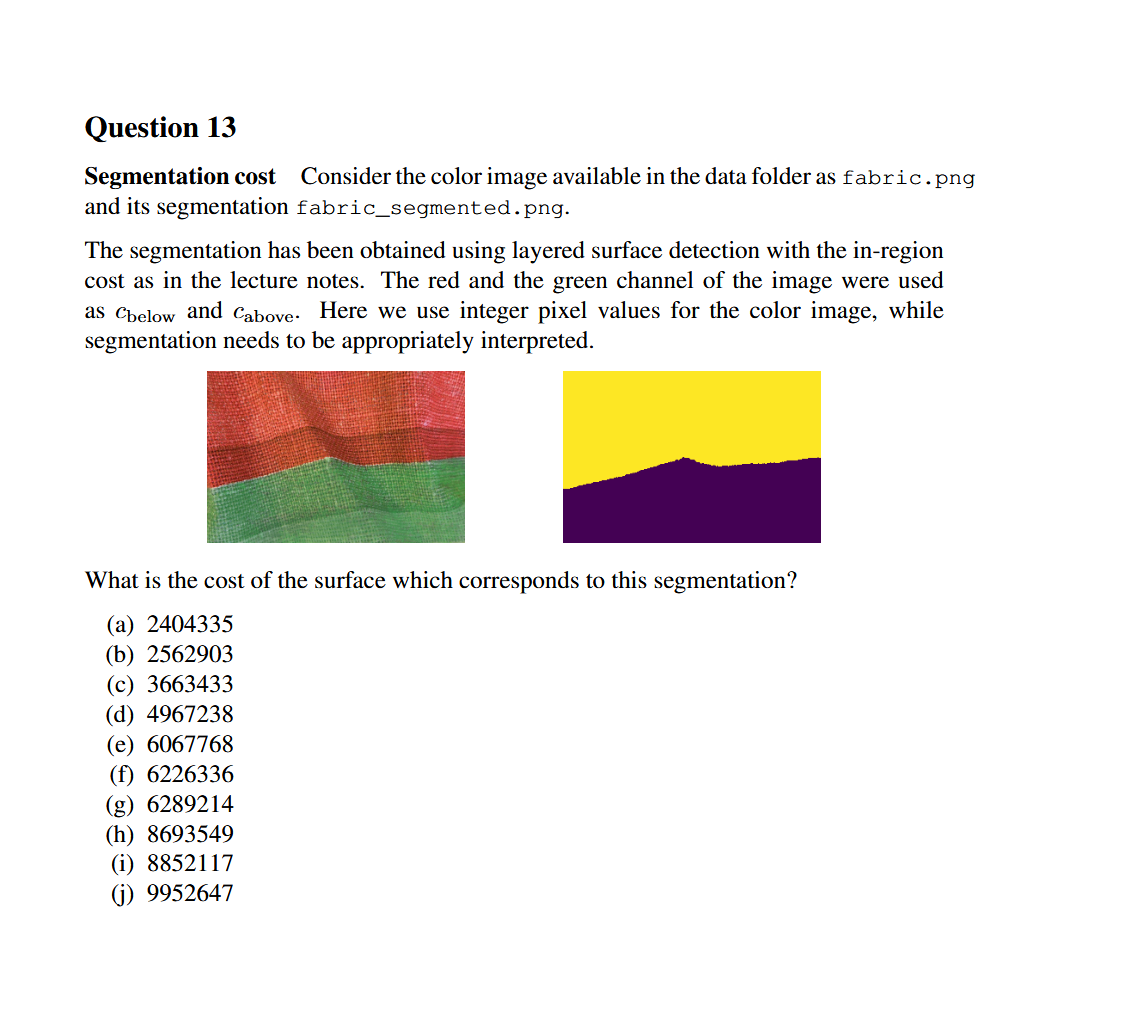

Image shape: (200, 300, 3)
Red channel (c_below) range: 40.0 - 255.0
Green channel (c_above) range: 10.0 - 223.0


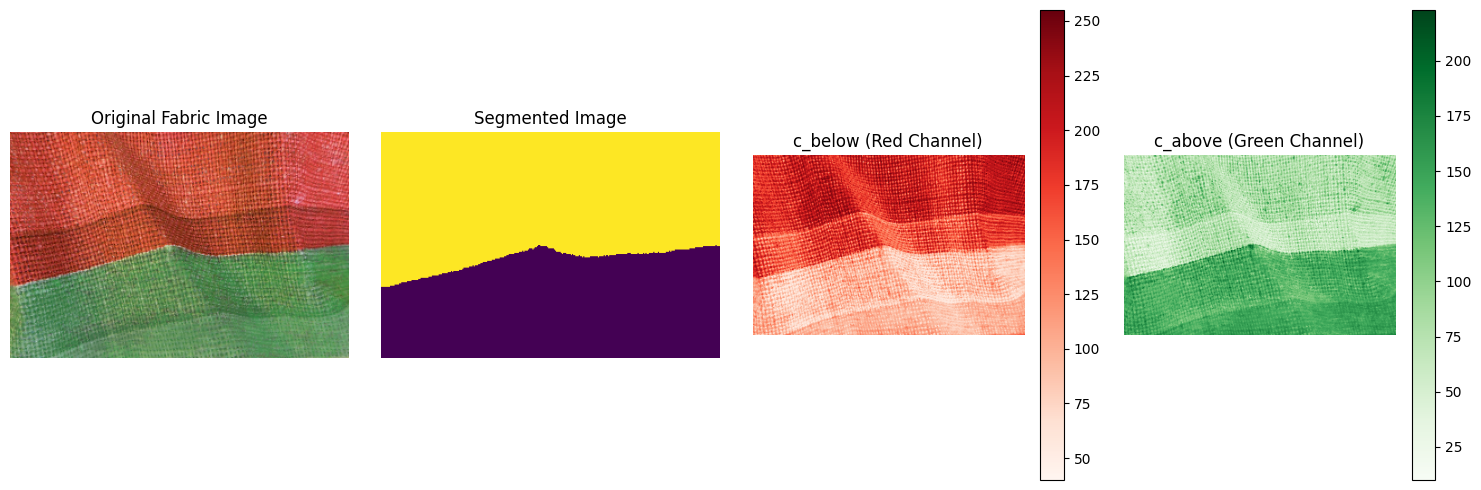

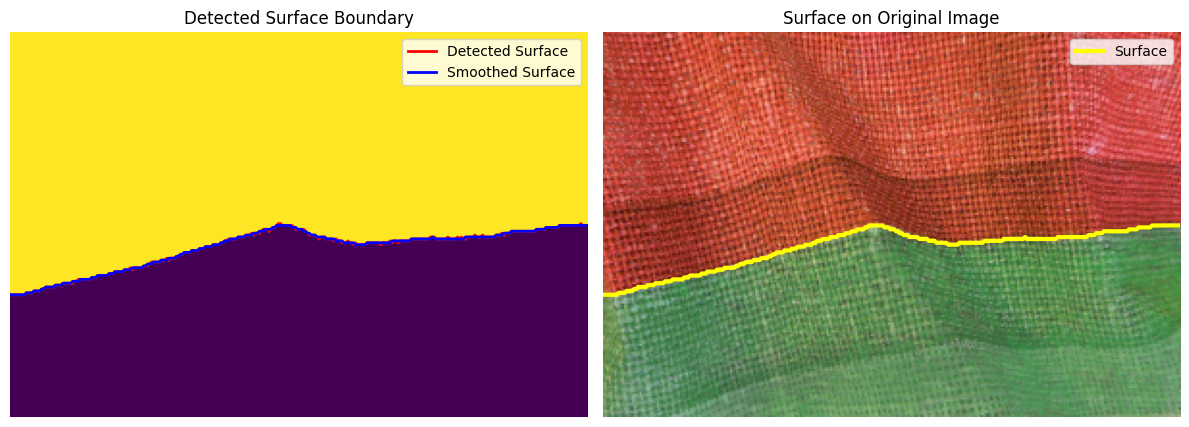


SEGMENTATION COST CALCULATION RESULTS
Total segmentation cost: 4973586
Surface length: 300 pixels
Average surface height: 112.0
Surface height range: 100 - 136

COMPARISON WITH ANSWER CHOICES
(a)  2404335 - Difference:  2569251
(b)  2562903 - Difference:  2410683
(c)  3663433 - Difference:  1310153
(d)  4967238 - Difference:     6348
(e)  6067768 - Difference:  1094182
(f)  6226336 - Difference:  1252750
(g)  6289214 - Difference:  1315628
(h)  8693549 - Difference:  3719963
(i)  8852117 - Difference:  3878531
(j)  9952647 - Difference:  4979061

Closest answer: (d) 4967238
Difference: 6348


In [1]:
import os
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage

def calculate_segmentation_cost(fabric_path, segmented_path):
    """
    Calculate the total cost of segmentation for layered surface detection.
    
    Parameters:
    fabric_path: path to the original color image (fabric.png)
    segmented_path: path to the segmented image (fabric_segmented.png)
    
    Returns:
    total_cost: the total cost of the segmentation surface
    """
    
    # Load the original color image
    fabric_image = skimage.io.imread(fabric_path)
    fabric_image = fabric_image.astype(float)
    
    # Load the segmented image
    segmented_image = skimage.io.imread(segmented_path)
    
    # Extract cost channels from original image
    # Assuming RGB format: [R, G, B] = [2, 1, 0] indices
    c_below = fabric_image[:, :, 0]  # Red channel
    c_above = fabric_image[:, :, 1]  # Green channel
    
    print(f"Image shape: {fabric_image.shape}")
    print(f"Red channel (c_below) range: {c_below.min():.1f} - {c_below.max():.1f}")
    print(f"Green channel (c_above) range: {c_above.min():.1f} - {c_above.max():.1f}")
    
    # Display the images
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 4, 1)
    plt.imshow(fabric_image.astype(np.uint8))
    plt.title('Original Fabric Image')
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.imshow(segmented_image)
    plt.title('Segmented Image')
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.imshow(c_below, cmap='Reds')
    plt.title('c_below (Red Channel)')
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.imshow(c_above, cmap='Greens')
    plt.title('c_above (Green Channel)')
    plt.colorbar()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Identify the surface boundary from segmentation
    # Convert segmented image to grayscale if needed
    if len(segmented_image.shape) == 3:
        # Convert to single channel for boundary detection
        seg_gray = np.mean(segmented_image, axis=2)
    else:
        seg_gray = segmented_image
    
    # Find the boundary between segments
    # Method 1: Find transition points column by column
    height, width = seg_gray.shape
    surface_points = np.zeros(width, dtype=int)
    
    for col in range(width):
        column = seg_gray[:, col]
        
        # Find the transition point (boundary)
        # Look for significant change in pixel values
        diff = np.abs(np.diff(column))
        if len(diff) > 0 and np.max(diff) > 0:
            # Find the largest transition
            boundary_idx = np.argmax(diff)
            surface_points[col] = boundary_idx
        else:
            # If no clear boundary, use middle
            surface_points[col] = height // 2
    
    # Smooth the surface to remove noise
    surface_points_smooth = scipy.ndimage.gaussian_filter1d(surface_points.astype(float), sigma=2)
    surface_points_smooth = np.round(surface_points_smooth).astype(int)
    
    # Ensure surface points are within image bounds
    surface_points_smooth = np.clip(surface_points_smooth, 0, height-1)
    
    # Visualize the detected surface
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.imshow(segmented_image)
    plt.plot(range(width), surface_points, 'r-', linewidth=2, label='Detected Surface')
    plt.plot(range(width), surface_points_smooth, 'b-', linewidth=2, label='Smoothed Surface')
    plt.title('Detected Surface Boundary')
    plt.legend()
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(fabric_image.astype(np.uint8))
    plt.plot(range(width), surface_points_smooth, 'yellow', linewidth=3, label='Surface')
    plt.title('Surface on Original Image')
    plt.legend()
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate the total cost
    total_cost = 0
    
    for col in range(width):
        surface_row = surface_points_smooth[col]
        
        # Cost for pixels above the surface (use c_above = green channel)
        for row in range(0, surface_row):
            total_cost += c_above[row, col]
        
        # Cost for pixels below the surface (use c_below = red channel)
        for row in range(surface_row, height):
            total_cost += c_below[row, col]
    
    return total_cost, surface_points_smooth

def main():
    """Main function to run the segmentation cost calculation."""
    
    # Define paths to the images
    fabric_path = 'data/fabric/fabric.png'
    segmented_path = 'data/fabric/fabric_segmentation.png'
    
    # Check if files exist
    if not os.path.exists(fabric_path):
        print(f"Error: {fabric_path} not found!")
        print("Please make sure the fabric.png file is in the current directory.")
        return
    
    if not os.path.exists(segmented_path):
        print(f"Error: {segmented_path} not found!")
        print("Please make sure the fabric_segmented.png file is in the current directory.")
        return
    
    # Calculate the segmentation cost
    try:
        total_cost, surface = calculate_segmentation_cost(fabric_path, segmented_path)
        
        print(f"\n" + "="*50)
        print(f"SEGMENTATION COST CALCULATION RESULTS")
        print(f"="*50)
        print(f"Total segmentation cost: {total_cost:.0f}")
        print(f"Surface length: {len(surface)} pixels")
        print(f"Average surface height: {np.mean(surface):.1f}")
        print(f"Surface height range: {np.min(surface)} - {np.max(surface)}")
        
        # Compare with given answer choices
        answer_choices = {
            'a': 2404335,
            'b': 2562903,
            'c': 3663433,
            'd': 4967238,
            'e': 6067768,
            'f': 6226336,
            'g': 6289214,
            'h': 8693549,
            'i': 8852117,
            'j': 9952647
        }
        
        print(f"\n" + "="*50)
        print(f"COMPARISON WITH ANSWER CHOICES")
        print(f"="*50)
        
        closest_answer = None
        min_diff = float('inf')
        
        for letter, value in answer_choices.items():
            diff = abs(total_cost - value)
            print(f"({letter}) {value:>8} - Difference: {diff:>8.0f}")
            
            if diff < min_diff:
                min_diff = diff
                closest_answer = letter
        
        print(f"\nClosest answer: ({closest_answer}) {answer_choices[closest_answer]}")
        print(f"Difference: {min_diff:.0f}")
        
    except Exception as e:
        print(f"Error calculating segmentation cost: {e}")
        print("Please check that your image files are valid and accessible.")

if __name__ == "__main__":
    main()